<b>EYE FOR BLIND</b>  
This notebook will be used to prepare the capstone project 'Eye for Blind'

# PROBLEM STATEMENT

Create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

The project is an extended application of Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper.


# IMPORT

In [1]:
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name="any")

In [111]:
import glob
from PIL import Image
from matplotlib.pyplot import imshow

import os
import pandas as pd
import numpy as np 

from tqdm import tqdm
import time
import datetime
import collections
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

import tensorflow as tf 
from tensorflow.keras import layers,Model 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.utils import plot_model 

from gtts import gTTS
import IPython

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

# DATA LOADING


1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions

## Read the image paths

In [3]:
#Import the dataset and read the image into a seperate variable

images='data/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))
#all_imgs[0]

The total images present in the dataset: 8091


## Read the captions file

In [4]:
#Import the dataset and read the text file into a seperate variable

captions_file = 'data/captions.txt'
def load_doc(filename):
    
    text_df = pd.read_csv(filename,sep=',')
    
    return text_df

captions_df = load_doc(captions_file)
display(captions_df.describe())
display(captions_df.head(2))

image                         caption
count                       40455                           40455
unique                       8091                           40201
top     1000268201_693b08cb0e.jpg  Two dogs playing in the snow .
freq                            5                               7

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .

## Visualize a sample image and its captions

Captions:
12105         A girl is smiling at the camera with a crowd of people behind her .
12106    A girl with long dark hair wearing a yellow and white shirt is smiling .
12107                                       A young girl smiling for the camera .
12108                            A young smiling girl wearing yellow in a crowd .
12109                              Young girl posing with crowd in the background
Name: caption, dtype: object


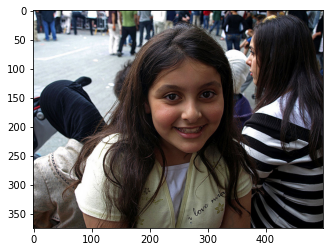

In [5]:
#Visualise both the images & text present in the dataset
image_path = all_imgs[1]
image_filename = os.path.basename(image_path)
im = Image.open(image_path)
imshow(im)

print(f'Captions:\n{captions_df[captions_df["image"]==image_filename]["caption"]}')

## Create a combined dataframe

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
filepaths_df = pd.DataFrame({'filename' : [os.path.basename(image_path) for image_path in all_imgs],
              'path' : all_imgs })
df = pd.merge(filepaths_df,captions_df,left_on='filename',right_on='image')
df.drop('image',axis=1, inplace=True)

print(f'Shape:{df.shape}')
df.head()

Shape:(40455, 3)


filename                                   path  \
0  2387197355_237f6f41ee.jpg  data/Images/2387197355_237f6f41ee.jpg   
1  2387197355_237f6f41ee.jpg  data/Images/2387197355_237f6f41ee.jpg   
2  2387197355_237f6f41ee.jpg  data/Images/2387197355_237f6f41ee.jpg   
3  2387197355_237f6f41ee.jpg  data/Images/2387197355_237f6f41ee.jpg   
4  2387197355_237f6f41ee.jpg  data/Images/2387197355_237f6f41ee.jpg   

                                                                      caption  
0                      A group of people are partying at a masquerade party .  
1            A lady in red and black grins at the camera at a costume party .  
2                    A woman in a domino mask and severe hair is at a party .  
3           A woman in a red dress and black mask is on a crowded dance floor  
4  A woman wears a red dress and a black mask while people dance behind her .

# TEMP CODE - CONSIDER ONLY TOP 1000 ROWS - TESTING

In [8]:
#df = df.head(100)

In [9]:
df.shape

(40455, 3)

In [10]:
# CLEAR CHECKPOINTS
import os
import glob

REMOVE_CHECKPOINTS = True
if (REMOVE_CHECKPOINTS):
    files = glob.glob('./checkpoints/train_chkpts/*')
    for f in files:
        os.remove(f)

# DATA PREPROCESSING

## Variables Initialization

In [12]:
 # Length of the vocabulary  
VOCAB_LENGTH = 5000

# Set batch size
BATCH_SIZE=16

# Set the buffer size
BUFFER_SIZE = 1000

In [13]:
# Stores .npy file with features from InceptionV3 for each image
# Can be done once and reused to save computation time
CREATE_FEATURE_NUMPY_FILE = False # Takes ~8min to create the batch features numpy file for all the images


## Pre-processing Captions

### Add the start & end tokens

In [14]:
df['caption'] = df['caption'].apply(lambda x: f'<start> {x} <end>')

In [15]:

print("Total captions present in the dataset: "+ str(len(df['caption'].unique())))
print("Total images present in the dataset: " + str(len(df['path'].unique())))

Total captions present in the dataset: 40201
Total images present in the dataset: 8091


1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Tokenize to words

In [19]:
# create the tokenizer
# Replace captions with UNK if word is not in the frequent words list

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_LENGTH,
                                                  oov_token="<UNK>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(df['caption'])    


### Pad sequences to longest length

In [20]:
    
# Add the <pad> tag to the vocabulary
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors: word-to-index mapping
caption_seqs = tokenizer.texts_to_sequences(df['caption'])

# Pad all sequences to be the same length as the longest one
captions_vector = tf.keras.preprocessing.sequence.pad_sequences(caption_seqs, padding='post')

# Map each caption to captions vector
cap_to_cap_vector = collections.defaultdict(list)
for cap, cap_vector in zip(df['caption'], captions_vector):
    cap_to_cap_vector[cap] = cap_vector


# Calculate the max_length of the caption, which is used to store the attention weights
max_length = max(len(x) for x in caption_seqs)


print(f'Total no. of captions      = {len(caption_seqs)}')
print(f'Total no. of token words   = {len(tokenizer.word_index) + 1}')
print(f'Vocab length for tokenizer = {VOCAB_LENGTH}')
print(f'Maximum caption length     = {max_length}')

Total no. of captions      = 40455
Total no. of token words   = 8498
Vocab length for tokenizer = 5000
Maximum caption length     = 39


### Visualize top-30 words

In [25]:
sort_orders = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
common_words = [{"word":i[0], "frequency":i[1]} for i in sort_orders]
common_words_df = pd.DataFrame(common_words)
display(common_words_df.head(30)) 

word  frequency
0         a      62992
1   <start>      40455
2     <end>      40455
3        in      18986
4       the      18419
5        on      10745
6        is       9345
7       and       8862
8       dog       8138
9      with       7765
10      man       7274
11       of       6723
12      two       5642
13    white       3959
14    black       3848
15      boy       3581
16      are       3504
17    woman       3402
18     girl       3328
19       to       3176
20  wearing       3062
21       at       2915
22   people       2883
23    water       2790
24      red       2691
25    young       2630
26    brown       2578
27       an       2432
28      his       2357
29     blue       2279

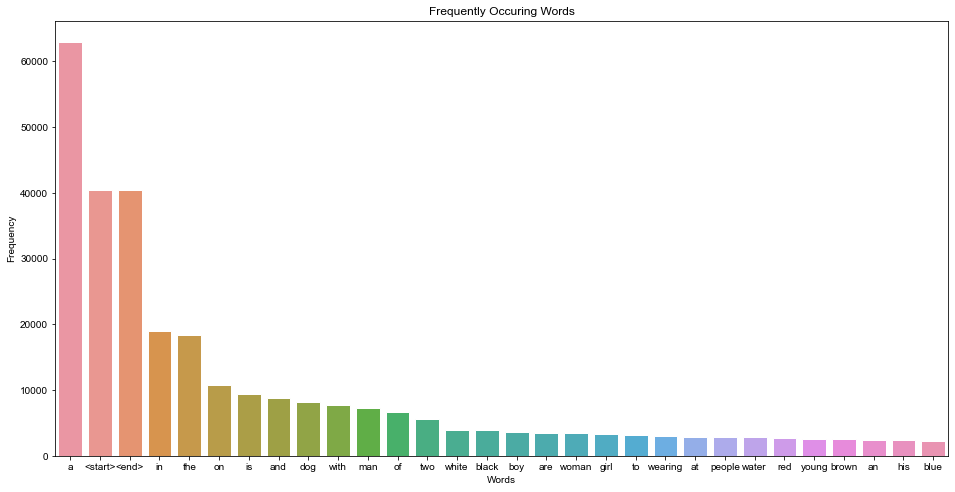

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 8))
sns.set_theme(style="darkgrid")
sns.barplot(x="word", y = 'frequency', data = common_words_df.head(30))
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequently Occuring Words") # You can comment this line out if you don't need title
plt.show()

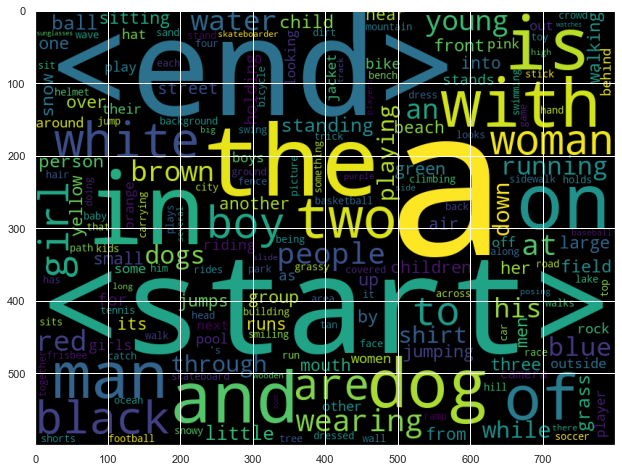

In [116]:
# Create a word cloud based on the word-frequency
common_words_dict = dict([tuple(x) for x in common_words_df.values])
wordcloud = WordCloud(width = 800, height = 600).generate_from_frequencies(common_words_dict)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)

## Pre-processing Images


1.Resize them into the shape of (299, 299)

2.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

<b> FAQs on how to resize the images::</b>
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [28]:
# Load an image from the path and preprocess it for InceptionV3
def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    # Preprocess the images using the preprocess_input method to normalize the image so that it 
    # contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# STORE PRETRAINED MODEL WEIGHTS

## Load all images using tf data

In [29]:
# Load dataset and apply the preprocessing to each image

# Get unique image paths
img_paths = sorted(df['path'].unique())

image_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
    

## Create an InceptionV3 model

In [30]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

#build the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [31]:
# Apply the InceptionV3 model on each image & resize it.
# Save the features for each image to be used later for training

if(CREATE_FEATURE_NUMPY_FILE):
    for imgs,paths in image_dataset:
        batch_features = image_features_extract_model(imgs)
        # batch_features.shape = (16, 8, 8, 2048) 
        # Reshape feature to (batch_size, 8*8, 2048)
        batch_features = tf.reshape(batch_features,
                                  (batch_features.shape[0], -1, batch_features.shape[3]))
        # Creates a .npy file for each image which has the features extracted from InceptionV3 for that image
        for bf, p in zip(batch_features, paths):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())
 

<b> FAQs on how to store the features: </b>
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

# PREPARE DATASET


1. Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2. Create a function which maps the image path to their feature. 

3. Create a builder function to create train & test dataset & apply the function to transform the dataset  
a. Make sure you have done Shuffle and batch while building the dataset   
b. The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)   
c. The shape of each caption in the dataset after building should be(batch_size, max_len)


## Train/Test Split

Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

In [32]:
path_train, path_test, cap_train_list, cap_test_list = train_test_split(
                                                    #df[['filename','path']],
                                                    df[['path']],
                                                    df['caption'],
                                                    test_size = 0.2, 
                                                    random_state = 42)


In [33]:
cap_train = []
for caption in cap_train_list:
    cap_train.append(cap_to_cap_vector[caption])
    
    
cap_test = []
for caption in cap_test_list:
    cap_test.append(cap_to_cap_vector[caption])

In [34]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


## Builder function to load features

In [35]:
# Mapping function to load the InceptionV3 features for the given image path

def map_func(img_name, cap):
  img_tensor = np.load(img_name[0].numpy().decode('utf-8')+'.npy')
  return img_tensor, cap

In [36]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func 

def gen_dataset(img_path,cap_data):
    img_dataset = tf.data.Dataset.from_tensor_slices((img_path,cap_data))
    
    img_dataset = img_dataset.map(lambda item1, item2: tf.py_function(
          map_func, [item1, item2], [tf.float32, tf.int32]), 
          num_parallel_calls=tf.data.AUTOTUNE) 
    
    # Shuffle and batch
    img_dataset = img_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    img_dataset = img_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return img_dataset,cap_data


In [37]:
# Read the preprocessed train & test datasets
train_dataset,cap_train_data=gen_dataset(path_train,cap_train)
test_dataset,cap_test_data=gen_dataset(path_test,cap_test)

In [38]:
# For verification
sample_img_batch, sample_cap_batch = next(iter(train_dataset)) 
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

2021-12-07 08:19:18.853943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-07 08:19:18.854539: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


(16, 64, 2048)
(16, 39)


# MODEL BUILDING


## Set Parameters

In [39]:
embedding_dim = 256 
units = 512
vocab_size = VOCAB_LENGTH + 1 #top 5,000 words +1
train_num_batches = len(path_train) // BATCH_SIZE
test_num_batches =  len(path_test) // BATCH_SIZE

print(f'Vocabulary size:{vocab_size}')
print(f'No. of train batches:{train_num_batches}')
print(f'No. of test batches:{test_num_batches}')

Vocabulary size:5001
No. of train batches:2022
No. of test batches:505


## Encoder

CNN Encoder:  
input image --> INCEPTIONV3 --> features --> FC DENSE LAYER (256) --> RELU --> encoder output (size: batch, 64, 256)

In [40]:
class Encoder(Model):
    # Pass the features extracted from V3 inception through a fully connected dense layer  
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features): 
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        features = tf.nn.relu(features)  
        return features
    

In [41]:
encoder=Encoder(embedding_dim)

## Attention model

(1) ATTENTION WEIGHTS

(a)  
&emsp;&emsp;    Encoder output  --> FC DENSE LAYER --> W1  
&emsp;&emsp;    (Feature Vector)  
&emsp;&emsp;    [INPUT 1: features]

(b)    
&emsp;&emsp;    RNN Hidden State --> FC DENSE LAYER --> W2  
&emsp;&emsp;    [INPUT 2: hidden]

(c)   
&emsp;&emsp;    W1 SUM W2 --> tanh --> FC DENSE LAYER (V) --> SOFTMAX --> Attention Weights



(2) CONTEXT VECTOR

&emsp;&emsp;Context Vector = Attention Weights x Feature Map


In [42]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        
        # Build dense layer for encoder output (feature vector)
        self.W1 = tf.keras.layers.Dense(units)
        
        # Build dense layer for RNN hidden layer
        self.W2 = tf.keras.layers.Dense(units)
        
        # Build the dense layer to combine the output of W1 and W2
        self.V = tf.keras.layers.Dense(1)  
        
        self.units=units

    def call(self, features, hidden):
        # input: features shape: (batch_size, 8*8, embedding_dim)
        # input: hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden shape to: (batch_size, 1, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
         
        # Build the score function to shape: (batch_size, 8*8, units)
        # This gives an unnormalized score for each image feature.
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
         
        # Extract the normalized attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.nn.softmax(score, axis=1) 
        
        # Create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  attention_weights * features
         
        # Reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
         
        return context_vector, attention_weights
    
    
    
    
    def get_config(self):
        config = {
                    "units": self.units,
                    "W1": self.W1,
                    "W2": self.W2,
                    "V": self.V        }
        return config 

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Decoder

RNN DECODER:  

1.   
Caption --> EMBEDDING LAYER --> Embedded Caption  


2.  
Image Features --> ATTENTION MODEL --> Context Vector
    
    
3.  
Embedded Caption CONCAT Context Vector --> GRU --> FC DENSE LAYER --> LOGITS DENSE LAYER --> Caption Output
    

In [43]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        
        # Initialize the Attention model
        self.attention = Attention_model(self.units)
        
        # Build the embedding layer for the caption
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        
        # Build the GRU for the RNN layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        # Build the fully connected dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        
        # Build the final fully connected logits layer to make the caption prediction from the vocabulary 
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    #@tf.autograph.experimental.do_not_convert
    def call(self,x,features=None, hidden=None):
    
        # Get the context vector & attention weights from the attention model
        # features shape:(16, 64, 256), hidden shape:(16, 512)
        # context_vector shape:(16, 256), attention_weights shape:(16, 64, 1)
        context_vector, attention_weights = self.attention(features, hidden) 
        
        # Embed the input caption word 
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        # x shape: (16,1), embed shape:(16, 1, 256)
        embed =  self.embed(x) 
         
        # Concatenate the embedded input word with the context vector from attention layer. 
        # Shape after concatenation: (batch_size, 1, embedding_dim + hidden_size)
        # embed-concat shape:(16, 1, 512)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) 
         
        # Extract the output & hidden state from GRU layer. 
        # Output shape : (batch_size, max_length, hidden_size)
        # output shape:(16, 1, 512)
        output,state = self.gru(embed)
        
        # Pass the output through a fully connected dense layer
        # shape == (batch_size, max_length, hidden_size)
        # output shape d1:(16, 1, 512)
        output = self.d1(output)
         
        # shape : (batch_size * max_length, hidden_size)
        # output reshape:(16, 512)
        output = tf.reshape(output, (-1, output.shape[2]))
         
        # Pass through the logits layer to get the final prediction
        # shape : (batch_size * max_length, vocab_size)
        # output shape d2:(16, 5001)
        output = self.d2(output) 
         
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
    
    def get_config(self):
        config = {
                    "units": self.units,
                    "attention": self.attention,
                    "embed": self.embed,
                    "gru": self.gru,
                    "d1": self.d1,
                    "d2": self.d2

        }
        return config
     

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    

In [44]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [45]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (16, 64, 256)
Predictions shape from Decoder: (16, 5001)
Attention weights shape from Decoder: (16, 64, 1)


# MODEL TRAINING & OPTIMIZATION

1.Set the optimizer & loss object

2.Create the checkpoint path

3.Create the training & testing step functions

4.Create the loss function for the test dataset

## Initialize variables & checkpoints

In [46]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [47]:
# Define the loss function to ignore the padded characters
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [48]:
# Set the checkpoints to store intermediate results
checkpoint_path = "./checkpoints/train_chkpts"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [49]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print(f'Restoring latest checkpoint:{ckpt_manager.latest_checkpoint}')
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)
    
print(f'Start epoch:{start_epoch}')

Start epoch:0


* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

## Train step function - teacher forcing

In [50]:
# Create the training step function 
@tf.function
def train_step(img_tensor, target):
    loss = 0
    # target.shape = (16,39)
    # initialize the hidden state for each batch as the captions are not related from image to image
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
     
    with tf.GradientTape() as tape: 
        features = encoder(img_tensor) 
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden) 
            loss += loss_function(target[:, i], predictions) 

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables)) 
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

## Test step function

In [51]:
# Test step function - actual prediction passed as input to the decoder.

#@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    # target.shape = (16,39)
    # initialize the hidden state for each batch as the captions are not related from image to image
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
     
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        
        predictions, hidden, _ = decoder(dec_input, features, hidden) 

        loss += loss_function(target[:, i], predictions)
        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)

    avg_loss = (loss / int(target.shape[1])) 
    return loss, avg_loss 

In [52]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset): 
        total_batch_loss, avg_batch_loss = test_step(img_tensor, target)
        total_loss += avg_batch_loss 
        
        if batch % 500 == 0:
            print(f'Test Loss: Batch: {batch}, '\
                  f'Total Batch Loss: {total_batch_loss:.4f}, Avg Batch Loss: {avg_batch_loss:.4f}, '\
                  f'Total Loss: {total_loss:.4f}')
         
    print(f'Test Loss: Batch: {batch}, Total Batch Loss: {total_batch_loss:.4f}, Avg Batch Loss: {avg_batch_loss:.4f}, Total Loss: {total_loss:.4f}')
    avg_test_loss = total_loss/test_num_batches
    return avg_test_loss

## Train the model

In [54]:
loss_plot = []
test_loss_plot = []
EPOCHS = 25

best_test_loss=100
for epoch in tqdm(range(start_epoch, start_epoch+EPOCHS)):
    
    print(f"START OF EPOCH:{epoch+1}/{start_epoch+EPOCHS}")
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        total_batch_loss, avg_batch_loss = train_step(img_tensor, target)
        total_loss += avg_batch_loss
        
        if batch % 100 == 0:
            print(f'Train Loss: Epoch: {epoch+1}, Batch: {batch}, '\
                  f'Batch Loss: {total_batch_loss:.4f}, Avg Batch Loss: {avg_batch_loss:.4f}, '\
                  f'Total Loss: {total_loss:.4f} - '\
                  f'{time.time()-start:.2f} sec')
    
    avg_train_loss=total_loss / train_num_batches
    
    # storing the epoch end loss value to plot later
    loss_plot.append(avg_train_loss)    
    
    print(f'Training completed for Epoch: {epoch+1}, Batch: {batch}, '\
          f' Total Loss: {total_loss:.4f},  Avg Train Loss: {avg_train_loss:.4f} - '\
          f'{time.time()-start:.2f} sec')
    
    avg_test_loss = test_loss_cal(test_dataset) 
    test_loss_plot.append(avg_test_loss)
    
    
    print(f'Epoch: {epoch+1}, Average Train Loss: {avg_train_loss:.4f}, Average Test Loss: {avg_test_loss:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    
    if avg_test_loss < best_test_loss:
        print(f'Test loss has been reduced from {best_test_loss:.3f} to {avg_test_loss:.3f}, epoch - {epoch+1}')
        best_test_loss = avg_test_loss
        
    # Save after every epoch
    ckpt_manager.save()

  0%|                                                                           | 0/25 [00:00<?, ?it/s]

START OF EPOCH:1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosit

  4%|██▌                                                            | 1/25 [18:56<7:34:42, 1136.78s/it]

START OF EPOCH:2/25
Train Loss: Epoch: 2, Batch: 0, Batch Loss: 42.2916, Avg Batch Loss: 1.0844, Total Loss: 1.0844 - 0.99 sec
Train Loss: Epoch: 2, Batch: 100, Batch Loss: 45.4998, Avg Batch Loss: 1.1667, Total Loss: 106.2059 - 37.71 sec
Train Loss: Epoch: 2, Batch: 200, Batch Loss: 32.0208, Avg Batch Loss: 0.8210, Total Loss: 208.5142 - 77.83 sec
Train Loss: Epoch: 2, Batch: 300, Batch Loss: 36.1275, Avg Batch Loss: 0.9263, Total Loss: 309.8110 - 118.04 sec
Train Loss: Epoch: 2, Batch: 400, Batch Loss: 35.4813, Avg Batch Loss: 0.9098, Total Loss: 408.5077 - 158.13 sec
Train Loss: Epoch: 2, Batch: 500, Batch Loss: 33.2753, Avg Batch Loss: 0.8532, Total Loss: 506.9848 - 197.93 sec
Train Loss: Epoch: 2, Batch: 600, Batch Loss: 33.6796, Avg Batch Loss: 0.8636, Total Loss: 603.3525 - 237.80 sec
Train Loss: Epoch: 2, Batch: 700, Batch Loss: 40.2613, Avg Batch Loss: 1.0323, Total Loss: 698.6823 - 277.55 sec
Train Loss: Epoch: 2, Batch: 800, Batch Loss: 35.3060, Avg Batch Loss: 0.9053, Total

  8%|█████                                                          | 2/25 [37:22<7:08:41, 1118.34s/it]

START OF EPOCH:3/25
Train Loss: Epoch: 3, Batch: 0, Batch Loss: 37.6436, Avg Batch Loss: 0.9652, Total Loss: 0.9652 - 1.10 sec
Train Loss: Epoch: 3, Batch: 100, Batch Loss: 31.3194, Avg Batch Loss: 0.8031, Total Loss: 89.8744 - 36.25 sec
Train Loss: Epoch: 3, Batch: 200, Batch Loss: 31.0783, Avg Batch Loss: 0.7969, Total Loss: 178.4603 - 76.57 sec
Train Loss: Epoch: 3, Batch: 300, Batch Loss: 34.2093, Avg Batch Loss: 0.8772, Total Loss: 267.9409 - 116.58 sec
Train Loss: Epoch: 3, Batch: 400, Batch Loss: 32.1896, Avg Batch Loss: 0.8254, Total Loss: 355.3858 - 156.56 sec
Train Loss: Epoch: 3, Batch: 500, Batch Loss: 37.7893, Avg Batch Loss: 0.9690, Total Loss: 442.8312 - 196.33 sec
Train Loss: Epoch: 3, Batch: 600, Batch Loss: 33.5458, Avg Batch Loss: 0.8601, Total Loss: 530.3891 - 236.24 sec
Train Loss: Epoch: 3, Batch: 700, Batch Loss: 34.4584, Avg Batch Loss: 0.8835, Total Loss: 617.6614 - 276.19 sec
Train Loss: Epoch: 3, Batch: 800, Batch Loss: 38.6471, Avg Batch Loss: 0.9910, Total 

 12%|███████▌                                                       | 3/25 [55:43<6:47:10, 1110.47s/it]

Test Loss: Batch: 505, Total Batch Loss: 85.8309, Avg Batch Loss: 2.2008, Total Loss: 972.7183
Epoch: 3, Average Train Loss: 0.8581, Average Test Loss: 1.9262
Time taken for 1 epoch 1100.90 sec

START OF EPOCH:4/25
Train Loss: Epoch: 4, Batch: 0, Batch Loss: 35.1861, Avg Batch Loss: 0.9022, Total Loss: 0.9022 - 1.12 sec
Train Loss: Epoch: 4, Batch: 100, Batch Loss: 36.6723, Avg Batch Loss: 0.9403, Total Loss: 83.8522 - 36.09 sec
Train Loss: Epoch: 4, Batch: 200, Batch Loss: 38.7301, Avg Batch Loss: 0.9931, Total Loss: 166.3749 - 76.15 sec
Train Loss: Epoch: 4, Batch: 300, Batch Loss: 40.2972, Avg Batch Loss: 1.0333, Total Loss: 249.0467 - 116.19 sec
Train Loss: Epoch: 4, Batch: 400, Batch Loss: 31.9967, Avg Batch Loss: 0.8204, Total Loss: 330.9328 - 156.62 sec
Train Loss: Epoch: 4, Batch: 500, Batch Loss: 29.7495, Avg Batch Loss: 0.7628, Total Loss: 412.5751 - 196.78 sec
Train Loss: Epoch: 4, Batch: 600, Batch Loss: 31.0371, Avg Batch Loss: 0.7958, Total Loss: 493.4411 - 236.91 sec
Tra

 16%|█████████▊                                                   | 4/25 [1:14:08<6:27:58, 1108.50s/it]

Test Loss: Batch: 505, Total Batch Loss: 67.8200, Avg Batch Loss: 1.7390, Total Loss: 975.0356
Epoch: 4, Average Train Loss: 0.8002, Average Test Loss: 1.9308
Time taken for 1 epoch 1105.27 sec

START OF EPOCH:5/25
Train Loss: Epoch: 5, Batch: 0, Batch Loss: 26.7589, Avg Batch Loss: 0.6861, Total Loss: 0.6861 - 1.11 sec
Train Loss: Epoch: 5, Batch: 100, Batch Loss: 35.2977, Avg Batch Loss: 0.9051, Total Loss: 78.3010 - 42.30 sec
Train Loss: Epoch: 5, Batch: 200, Batch Loss: 34.0218, Avg Batch Loss: 0.8724, Total Loss: 155.6300 - 87.50 sec
Train Loss: Epoch: 5, Batch: 300, Batch Loss: 27.5059, Avg Batch Loss: 0.7053, Total Loss: 232.7464 - 129.01 sec
Train Loss: Epoch: 5, Batch: 400, Batch Loss: 29.7983, Avg Batch Loss: 0.7641, Total Loss: 308.4029 - 171.90 sec
Train Loss: Epoch: 5, Batch: 500, Batch Loss: 35.2739, Avg Batch Loss: 0.9045, Total Loss: 385.4063 - 215.95 sec
Train Loss: Epoch: 5, Batch: 600, Batch Loss: 29.1988, Avg Batch Loss: 0.7487, Total Loss: 461.9555 - 257.26 sec
Tra

 20%|████████████▏                                                | 5/25 [1:33:12<6:13:45, 1121.29s/it]

START OF EPOCH:6/25
Train Loss: Epoch: 6, Batch: 0, Batch Loss: 26.1637, Avg Batch Loss: 0.6709, Total Loss: 0.6709 - 1.19 sec
Train Loss: Epoch: 6, Batch: 100, Batch Loss: 28.4515, Avg Batch Loss: 0.7295, Total Loss: 72.0108 - 40.00 sec
Train Loss: Epoch: 6, Batch: 200, Batch Loss: 33.6531, Avg Batch Loss: 0.8629, Total Loss: 144.8350 - 81.51 sec
Train Loss: Epoch: 6, Batch: 300, Batch Loss: 30.5826, Avg Batch Loss: 0.7842, Total Loss: 218.2030 - 123.20 sec
Train Loss: Epoch: 6, Batch: 400, Batch Loss: 28.1066, Avg Batch Loss: 0.7207, Total Loss: 291.0023 - 165.16 sec
Train Loss: Epoch: 6, Batch: 500, Batch Loss: 28.7405, Avg Batch Loss: 0.7369, Total Loss: 362.5265 - 206.66 sec
Train Loss: Epoch: 6, Batch: 600, Batch Loss: 21.6402, Avg Batch Loss: 0.5549, Total Loss: 433.4701 - 247.92 sec
Train Loss: Epoch: 6, Batch: 700, Batch Loss: 24.8037, Avg Batch Loss: 0.6360, Total Loss: 505.6566 - 288.20 sec
Train Loss: Epoch: 6, Batch: 800, Batch Loss: 25.0442, Avg Batch Loss: 0.6422, Total 

 24%|██████████████▋                                              | 6/25 [1:51:53<5:55:03, 1121.25s/it]

Test Loss: Batch: 505, Total Batch Loss: 56.6176, Avg Batch Loss: 1.4517, Total Loss: 1004.5573
Epoch: 6, Average Train Loss: 0.7037, Average Test Loss: 1.9892
Time taken for 1 epoch 1120.98 sec

START OF EPOCH:7/25
Train Loss: Epoch: 7, Batch: 0, Batch Loss: 30.8898, Avg Batch Loss: 0.7920, Total Loss: 0.7920 - 0.96 sec
Train Loss: Epoch: 7, Batch: 100, Batch Loss: 32.7436, Avg Batch Loss: 0.8396, Total Loss: 69.6109 - 41.01 sec
Train Loss: Epoch: 7, Batch: 200, Batch Loss: 27.0157, Avg Batch Loss: 0.6927, Total Loss: 137.8849 - 80.96 sec
Train Loss: Epoch: 7, Batch: 300, Batch Loss: 24.4914, Avg Batch Loss: 0.6280, Total Loss: 206.1046 - 120.85 sec
Train Loss: Epoch: 7, Batch: 400, Batch Loss: 25.9795, Avg Batch Loss: 0.6661, Total Loss: 272.6414 - 160.86 sec
Train Loss: Epoch: 7, Batch: 500, Batch Loss: 29.7414, Avg Batch Loss: 0.7626, Total Loss: 339.7199 - 200.70 sec
Train Loss: Epoch: 7, Batch: 600, Batch Loss: 26.1635, Avg Batch Loss: 0.6709, Total Loss: 407.3844 - 240.70 sec
Tr

 28%|█████████████████                                            | 7/25 [2:10:31<5:35:58, 1119.91s/it]

START OF EPOCH:8/25
Train Loss: Epoch: 8, Batch: 0, Batch Loss: 33.5473, Avg Batch Loss: 0.8602, Total Loss: 0.8602 - 1.13 sec
Train Loss: Epoch: 8, Batch: 100, Batch Loss: 23.2233, Avg Batch Loss: 0.5955, Total Loss: 63.9384 - 41.34 sec
Train Loss: Epoch: 8, Batch: 200, Batch Loss: 29.8305, Avg Batch Loss: 0.7649, Total Loss: 128.9468 - 81.68 sec
Train Loss: Epoch: 8, Batch: 300, Batch Loss: 18.7850, Avg Batch Loss: 0.4817, Total Loss: 192.9742 - 121.70 sec
Train Loss: Epoch: 8, Batch: 400, Batch Loss: 22.6108, Avg Batch Loss: 0.5798, Total Loss: 256.4636 - 161.86 sec
Train Loss: Epoch: 8, Batch: 500, Batch Loss: 25.3102, Avg Batch Loss: 0.6490, Total Loss: 319.6935 - 201.82 sec
Train Loss: Epoch: 8, Batch: 600, Batch Loss: 20.8796, Avg Batch Loss: 0.5354, Total Loss: 383.0807 - 241.62 sec
Train Loss: Epoch: 8, Batch: 700, Batch Loss: 24.5712, Avg Batch Loss: 0.6300, Total Loss: 445.2866 - 281.42 sec
Train Loss: Epoch: 8, Batch: 800, Batch Loss: 25.8707, Avg Batch Loss: 0.6634, Total 

 32%|███████████████████▌                                         | 8/25 [2:29:02<5:16:33, 1117.29s/it]

START OF EPOCH:9/25
Train Loss: Epoch: 9, Batch: 0, Batch Loss: 23.5843, Avg Batch Loss: 0.6047, Total Loss: 0.6047 - 1.13 sec
Train Loss: Epoch: 9, Batch: 100, Batch Loss: 27.0239, Avg Batch Loss: 0.6929, Total Loss: 61.1122 - 40.96 sec
Train Loss: Epoch: 9, Batch: 200, Batch Loss: 17.7834, Avg Batch Loss: 0.4560, Total Loss: 121.2800 - 80.72 sec
Train Loss: Epoch: 9, Batch: 300, Batch Loss: 25.0754, Avg Batch Loss: 0.6430, Total Loss: 181.1643 - 120.59 sec
Train Loss: Epoch: 9, Batch: 400, Batch Loss: 24.9172, Avg Batch Loss: 0.6389, Total Loss: 239.6412 - 160.49 sec
Train Loss: Epoch: 9, Batch: 500, Batch Loss: 25.1738, Avg Batch Loss: 0.6455, Total Loss: 299.5121 - 200.23 sec
Train Loss: Epoch: 9, Batch: 600, Batch Loss: 29.9420, Avg Batch Loss: 0.7677, Total Loss: 359.5711 - 240.11 sec
Train Loss: Epoch: 9, Batch: 700, Batch Loss: 21.8826, Avg Batch Loss: 0.5611, Total Loss: 418.8696 - 279.85 sec
Train Loss: Epoch: 9, Batch: 800, Batch Loss: 20.7995, Avg Batch Loss: 0.5333, Total 

 36%|█████████████████████▉                                       | 9/25 [2:47:26<4:56:49, 1113.06s/it]

START OF EPOCH:10/25
Train Loss: Epoch: 10, Batch: 0, Batch Loss: 25.3760, Avg Batch Loss: 0.6507, Total Loss: 0.6507 - 1.11 sec
Train Loss: Epoch: 10, Batch: 100, Batch Loss: 24.4146, Avg Batch Loss: 0.6260, Total Loss: 57.3199 - 38.98 sec
Train Loss: Epoch: 10, Batch: 200, Batch Loss: 21.9729, Avg Batch Loss: 0.5634, Total Loss: 114.2560 - 79.10 sec
Train Loss: Epoch: 10, Batch: 300, Batch Loss: 22.2778, Avg Batch Loss: 0.5712, Total Loss: 171.6668 - 119.27 sec
Train Loss: Epoch: 10, Batch: 400, Batch Loss: 17.1511, Avg Batch Loss: 0.4398, Total Loss: 226.8303 - 159.51 sec
Train Loss: Epoch: 10, Batch: 500, Batch Loss: 24.7102, Avg Batch Loss: 0.6336, Total Loss: 282.6892 - 199.63 sec
Train Loss: Epoch: 10, Batch: 600, Batch Loss: 21.3969, Avg Batch Loss: 0.5486, Total Loss: 338.8530 - 239.70 sec
Train Loss: Epoch: 10, Batch: 700, Batch Loss: 21.1843, Avg Batch Loss: 0.5432, Total Loss: 394.3771 - 280.05 sec
Train Loss: Epoch: 10, Batch: 800, Batch Loss: 19.1900, Avg Batch Loss: 0.49

 40%|████████████████████████                                    | 10/25 [3:06:19<4:39:50, 1119.34s/it]

START OF EPOCH:11/25
Train Loss: Epoch: 11, Batch: 0, Batch Loss: 23.3394, Avg Batch Loss: 0.5984, Total Loss: 0.5984 - 1.20 sec
Train Loss: Epoch: 11, Batch: 100, Batch Loss: 27.5672, Avg Batch Loss: 0.7069, Total Loss: 53.9009 - 39.10 sec
Train Loss: Epoch: 11, Batch: 200, Batch Loss: 17.4968, Avg Batch Loss: 0.4486, Total Loss: 107.7792 - 79.65 sec
Train Loss: Epoch: 11, Batch: 300, Batch Loss: 19.1559, Avg Batch Loss: 0.4912, Total Loss: 161.8964 - 120.52 sec
Train Loss: Epoch: 11, Batch: 400, Batch Loss: 21.8683, Avg Batch Loss: 0.5607, Total Loss: 213.8591 - 161.41 sec
Train Loss: Epoch: 11, Batch: 500, Batch Loss: 17.1942, Avg Batch Loss: 0.4409, Total Loss: 266.7754 - 202.37 sec
Train Loss: Epoch: 11, Batch: 600, Batch Loss: 22.8845, Avg Batch Loss: 0.5868, Total Loss: 321.1600 - 243.10 sec
Train Loss: Epoch: 11, Batch: 700, Batch Loss: 20.1417, Avg Batch Loss: 0.5165, Total Loss: 374.0420 - 283.74 sec
Train Loss: Epoch: 11, Batch: 800, Batch Loss: 21.1553, Avg Batch Loss: 0.54

 44%|██████████████████████████▍                                 | 11/25 [3:25:00<4:21:17, 1119.80s/it]

START OF EPOCH:12/25
Train Loss: Epoch: 12, Batch: 0, Batch Loss: 20.6929, Avg Batch Loss: 0.5306, Total Loss: 0.5306 - 1.13 sec
Train Loss: Epoch: 12, Batch: 100, Batch Loss: 19.5289, Avg Batch Loss: 0.5007, Total Loss: 51.3609 - 40.59 sec
Train Loss: Epoch: 12, Batch: 200, Batch Loss: 17.7322, Avg Batch Loss: 0.4547, Total Loss: 102.3699 - 81.02 sec
Train Loss: Epoch: 12, Batch: 300, Batch Loss: 20.9951, Avg Batch Loss: 0.5383, Total Loss: 153.2844 - 121.22 sec
Train Loss: Epoch: 12, Batch: 400, Batch Loss: 21.0306, Avg Batch Loss: 0.5392, Total Loss: 203.4781 - 161.58 sec
Train Loss: Epoch: 12, Batch: 500, Batch Loss: 21.9926, Avg Batch Loss: 0.5639, Total Loss: 254.3676 - 201.85 sec
Train Loss: Epoch: 12, Batch: 600, Batch Loss: 18.6780, Avg Batch Loss: 0.4789, Total Loss: 304.4935 - 242.13 sec
Train Loss: Epoch: 12, Batch: 700, Batch Loss: 25.6469, Avg Batch Loss: 0.6576, Total Loss: 355.7587 - 282.64 sec
Train Loss: Epoch: 12, Batch: 800, Batch Loss: 20.9405, Avg Batch Loss: 0.53

 48%|████████████████████████████▊                               | 12/25 [3:43:40<4:02:37, 1119.83s/it]

START OF EPOCH:13/25
Train Loss: Epoch: 13, Batch: 0, Batch Loss: 17.7834, Avg Batch Loss: 0.4560, Total Loss: 0.4560 - 1.19 sec
Train Loss: Epoch: 13, Batch: 100, Batch Loss: 15.4041, Avg Batch Loss: 0.3950, Total Loss: 48.8218 - 42.23 sec
Train Loss: Epoch: 13, Batch: 200, Batch Loss: 15.4718, Avg Batch Loss: 0.3967, Total Loss: 96.6626 - 82.70 sec
Train Loss: Epoch: 13, Batch: 300, Batch Loss: 14.4112, Avg Batch Loss: 0.3695, Total Loss: 145.7222 - 124.31 sec
Train Loss: Epoch: 13, Batch: 400, Batch Loss: 21.1315, Avg Batch Loss: 0.5418, Total Loss: 193.1118 - 165.51 sec
Train Loss: Epoch: 13, Batch: 500, Batch Loss: 18.4054, Avg Batch Loss: 0.4719, Total Loss: 239.6454 - 206.41 sec
Train Loss: Epoch: 13, Batch: 600, Batch Loss: 20.4327, Avg Batch Loss: 0.5239, Total Loss: 287.7380 - 248.08 sec
Train Loss: Epoch: 13, Batch: 700, Batch Loss: 14.9395, Avg Batch Loss: 0.3831, Total Loss: 335.3096 - 289.25 sec
Train Loss: Epoch: 13, Batch: 800, Batch Loss: 18.7776, Avg Batch Loss: 0.481

 52%|███████████████████████████████▏                            | 13/25 [4:02:26<3:44:19, 1121.62s/it]

START OF EPOCH:14/25
Train Loss: Epoch: 14, Batch: 0, Batch Loss: 20.6151, Avg Batch Loss: 0.5286, Total Loss: 0.5286 - 1.22 sec
Train Loss: Epoch: 14, Batch: 100, Batch Loss: 16.1740, Avg Batch Loss: 0.4147, Total Loss: 46.8999 - 36.70 sec
Train Loss: Epoch: 14, Batch: 200, Batch Loss: 19.9662, Avg Batch Loss: 0.5120, Total Loss: 92.2205 - 76.93 sec
Train Loss: Epoch: 14, Batch: 300, Batch Loss: 15.6754, Avg Batch Loss: 0.4019, Total Loss: 139.1911 - 117.01 sec
Train Loss: Epoch: 14, Batch: 400, Batch Loss: 19.1587, Avg Batch Loss: 0.4912, Total Loss: 183.5042 - 156.86 sec
Train Loss: Epoch: 14, Batch: 500, Batch Loss: 19.0258, Avg Batch Loss: 0.4878, Total Loss: 228.8744 - 196.95 sec
Train Loss: Epoch: 14, Batch: 600, Batch Loss: 17.5057, Avg Batch Loss: 0.4489, Total Loss: 274.5496 - 236.77 sec
Train Loss: Epoch: 14, Batch: 700, Batch Loss: 15.7513, Avg Batch Loss: 0.4039, Total Loss: 320.5033 - 277.48 sec
Train Loss: Epoch: 14, Batch: 800, Batch Loss: 19.5431, Avg Batch Loss: 0.501

 56%|█████████████████████████████████▌                          | 14/25 [4:21:11<3:25:48, 1122.60s/it]

START OF EPOCH:15/25
Train Loss: Epoch: 15, Batch: 0, Batch Loss: 20.2424, Avg Batch Loss: 0.5190, Total Loss: 0.5190 - 1.28 sec
Train Loss: Epoch: 15, Batch: 100, Batch Loss: 17.7306, Avg Batch Loss: 0.4546, Total Loss: 44.5399 - 43.76 sec
Train Loss: Epoch: 15, Batch: 200, Batch Loss: 14.9552, Avg Batch Loss: 0.3835, Total Loss: 87.9550 - 86.05 sec
Train Loss: Epoch: 15, Batch: 300, Batch Loss: 18.1851, Avg Batch Loss: 0.4663, Total Loss: 132.1654 - 128.15 sec
Train Loss: Epoch: 15, Batch: 400, Batch Loss: 12.8899, Avg Batch Loss: 0.3305, Total Loss: 175.0692 - 170.19 sec
Train Loss: Epoch: 15, Batch: 500, Batch Loss: 16.5297, Avg Batch Loss: 0.4238, Total Loss: 218.2229 - 211.85 sec
Train Loss: Epoch: 15, Batch: 600, Batch Loss: 14.6562, Avg Batch Loss: 0.3758, Total Loss: 261.6361 - 253.37 sec
Train Loss: Epoch: 15, Batch: 700, Batch Loss: 16.4098, Avg Batch Loss: 0.4208, Total Loss: 305.8346 - 295.02 sec
Train Loss: Epoch: 15, Batch: 800, Batch Loss: 14.0501, Avg Batch Loss: 0.360

 60%|████████████████████████████████████                        | 15/25 [4:40:17<3:08:17, 1129.80s/it]

START OF EPOCH:16/25
Train Loss: Epoch: 16, Batch: 0, Batch Loss: 18.6731, Avg Batch Loss: 0.4788, Total Loss: 0.4788 - 1.20 sec
Train Loss: Epoch: 16, Batch: 100, Batch Loss: 14.1472, Avg Batch Loss: 0.3627, Total Loss: 42.0667 - 39.72 sec
Train Loss: Epoch: 16, Batch: 200, Batch Loss: 19.4387, Avg Batch Loss: 0.4984, Total Loss: 84.6669 - 79.87 sec
Train Loss: Epoch: 16, Batch: 300, Batch Loss: 13.9156, Avg Batch Loss: 0.3568, Total Loss: 126.5140 - 119.90 sec
Train Loss: Epoch: 16, Batch: 400, Batch Loss: 16.9926, Avg Batch Loss: 0.4357, Total Loss: 167.8799 - 160.06 sec
Train Loss: Epoch: 16, Batch: 500, Batch Loss: 13.8456, Avg Batch Loss: 0.3550, Total Loss: 209.2374 - 200.17 sec
Train Loss: Epoch: 16, Batch: 600, Batch Loss: 14.8289, Avg Batch Loss: 0.3802, Total Loss: 250.4043 - 240.30 sec
Train Loss: Epoch: 16, Batch: 700, Batch Loss: 17.3210, Avg Batch Loss: 0.4441, Total Loss: 292.2494 - 280.53 sec
Train Loss: Epoch: 16, Batch: 800, Batch Loss: 13.7528, Avg Batch Loss: 0.352

 64%|██████████████████████████████████████▍                     | 16/25 [4:58:57<2:49:02, 1126.89s/it]

START OF EPOCH:17/25
Train Loss: Epoch: 17, Batch: 0, Batch Loss: 17.1020, Avg Batch Loss: 0.4385, Total Loss: 0.4385 - 1.22 sec
Train Loss: Epoch: 17, Batch: 100, Batch Loss: 14.5413, Avg Batch Loss: 0.3729, Total Loss: 41.3679 - 50.17 sec
Train Loss: Epoch: 17, Batch: 200, Batch Loss: 17.5799, Avg Batch Loss: 0.4508, Total Loss: 81.2443 - 95.00 sec
Train Loss: Epoch: 17, Batch: 300, Batch Loss: 13.6761, Avg Batch Loss: 0.3507, Total Loss: 121.9800 - 138.95 sec
Train Loss: Epoch: 17, Batch: 400, Batch Loss: 14.7048, Avg Batch Loss: 0.3770, Total Loss: 161.7562 - 181.57 sec
Train Loss: Epoch: 17, Batch: 500, Batch Loss: 16.8930, Avg Batch Loss: 0.4332, Total Loss: 202.0481 - 224.39 sec
Train Loss: Epoch: 17, Batch: 600, Batch Loss: 19.0037, Avg Batch Loss: 0.4873, Total Loss: 242.5859 - 269.83 sec
Train Loss: Epoch: 17, Batch: 700, Batch Loss: 14.9323, Avg Batch Loss: 0.3829, Total Loss: 282.8535 - 315.66 sec
Train Loss: Epoch: 17, Batch: 800, Batch Loss: 13.7004, Avg Batch Loss: 0.351

 68%|████████████████████████████████████████▊                   | 17/25 [5:18:20<2:31:40, 1137.53s/it]

START OF EPOCH:18/25
Train Loss: Epoch: 18, Batch: 0, Batch Loss: 19.9276, Avg Batch Loss: 0.5110, Total Loss: 0.5110 - 1.21 sec
Train Loss: Epoch: 18, Batch: 100, Batch Loss: 14.1696, Avg Batch Loss: 0.3633, Total Loss: 39.9029 - 40.58 sec
Train Loss: Epoch: 18, Batch: 200, Batch Loss: 17.0728, Avg Batch Loss: 0.4378, Total Loss: 78.7368 - 80.91 sec
Train Loss: Epoch: 18, Batch: 300, Batch Loss: 15.4224, Avg Batch Loss: 0.3954, Total Loss: 117.4286 - 121.08 sec
Train Loss: Epoch: 18, Batch: 400, Batch Loss: 13.7047, Avg Batch Loss: 0.3514, Total Loss: 154.9481 - 161.62 sec
Train Loss: Epoch: 18, Batch: 500, Batch Loss: 15.8349, Avg Batch Loss: 0.4060, Total Loss: 193.3365 - 201.95 sec
Train Loss: Epoch: 18, Batch: 600, Batch Loss: 15.8108, Avg Batch Loss: 0.4054, Total Loss: 231.9931 - 242.02 sec
Train Loss: Epoch: 18, Batch: 700, Batch Loss: 19.1153, Avg Batch Loss: 0.4901, Total Loss: 269.9180 - 282.13 sec
Train Loss: Epoch: 18, Batch: 800, Batch Loss: 17.6030, Avg Batch Loss: 0.451

 72%|███████████████████████████████████████████▏                | 18/25 [5:36:52<2:11:49, 1129.90s/it]

START OF EPOCH:19/25
Train Loss: Epoch: 19, Batch: 0, Batch Loss: 16.6229, Avg Batch Loss: 0.4262, Total Loss: 0.4262 - 1.21 sec
Train Loss: Epoch: 19, Batch: 100, Batch Loss: 13.2336, Avg Batch Loss: 0.3393, Total Loss: 38.0860 - 37.22 sec
Train Loss: Epoch: 19, Batch: 200, Batch Loss: 14.7538, Avg Batch Loss: 0.3783, Total Loss: 75.8683 - 77.49 sec
Train Loss: Epoch: 19, Batch: 300, Batch Loss: 11.5412, Avg Batch Loss: 0.2959, Total Loss: 113.8718 - 117.69 sec
Train Loss: Epoch: 19, Batch: 400, Batch Loss: 16.1729, Avg Batch Loss: 0.4147, Total Loss: 150.6247 - 157.95 sec
Train Loss: Epoch: 19, Batch: 500, Batch Loss: 16.7547, Avg Batch Loss: 0.4296, Total Loss: 188.2334 - 197.96 sec
Train Loss: Epoch: 19, Batch: 600, Batch Loss: 16.1189, Avg Batch Loss: 0.4133, Total Loss: 224.6680 - 238.01 sec
Train Loss: Epoch: 19, Batch: 700, Batch Loss: 13.4633, Avg Batch Loss: 0.3452, Total Loss: 261.8245 - 278.08 sec
Train Loss: Epoch: 19, Batch: 800, Batch Loss: 11.8672, Avg Batch Loss: 0.304

 76%|█████████████████████████████████████████████▌              | 19/25 [5:55:08<1:51:59, 1119.88s/it]

START OF EPOCH:20/25
Train Loss: Epoch: 20, Batch: 0, Batch Loss: 15.0936, Avg Batch Loss: 0.3870, Total Loss: 0.3870 - 1.19 sec
Train Loss: Epoch: 20, Batch: 100, Batch Loss: 15.2269, Avg Batch Loss: 0.3904, Total Loss: 36.9377 - 39.70 sec
Train Loss: Epoch: 20, Batch: 200, Batch Loss: 16.0491, Avg Batch Loss: 0.4115, Total Loss: 73.0978 - 79.76 sec
Train Loss: Epoch: 20, Batch: 300, Batch Loss: 8.3019, Avg Batch Loss: 0.2129, Total Loss: 109.3586 - 119.70 sec
Train Loss: Epoch: 20, Batch: 400, Batch Loss: 15.6831, Avg Batch Loss: 0.4021, Total Loss: 144.5356 - 159.83 sec
Train Loss: Epoch: 20, Batch: 500, Batch Loss: 14.2092, Avg Batch Loss: 0.3643, Total Loss: 179.8994 - 200.06 sec
Train Loss: Epoch: 20, Batch: 600, Batch Loss: 14.1423, Avg Batch Loss: 0.3626, Total Loss: 215.9792 - 239.96 sec
Train Loss: Epoch: 20, Batch: 700, Batch Loss: 13.0314, Avg Batch Loss: 0.3341, Total Loss: 252.3411 - 280.17 sec
Train Loss: Epoch: 20, Batch: 800, Batch Loss: 13.8734, Avg Batch Loss: 0.3557

 80%|████████████████████████████████████████████████            | 20/25 [6:13:31<1:32:53, 1114.62s/it]

START OF EPOCH:21/25
Train Loss: Epoch: 21, Batch: 0, Batch Loss: 19.2744, Avg Batch Loss: 0.4942, Total Loss: 0.4942 - 1.18 sec
Train Loss: Epoch: 21, Batch: 100, Batch Loss: 13.0710, Avg Batch Loss: 0.3352, Total Loss: 35.6182 - 39.07 sec
Train Loss: Epoch: 21, Batch: 200, Batch Loss: 14.7594, Avg Batch Loss: 0.3784, Total Loss: 70.9470 - 79.09 sec
Train Loss: Epoch: 21, Batch: 300, Batch Loss: 12.1914, Avg Batch Loss: 0.3126, Total Loss: 106.1870 - 119.60 sec
Train Loss: Epoch: 21, Batch: 400, Batch Loss: 12.0972, Avg Batch Loss: 0.3102, Total Loss: 140.4702 - 159.57 sec
Train Loss: Epoch: 21, Batch: 500, Batch Loss: 12.1794, Avg Batch Loss: 0.3123, Total Loss: 174.5972 - 199.57 sec
Train Loss: Epoch: 21, Batch: 600, Batch Loss: 16.1987, Avg Batch Loss: 0.4154, Total Loss: 209.2287 - 239.69 sec
Train Loss: Epoch: 21, Batch: 700, Batch Loss: 13.6695, Avg Batch Loss: 0.3505, Total Loss: 243.6563 - 279.62 sec
Train Loss: Epoch: 21, Batch: 800, Batch Loss: 11.9576, Avg Batch Loss: 0.306

 84%|██████████████████████████████████████████████████▍         | 21/25 [6:32:02<1:14:14, 1113.66s/it]

START OF EPOCH:22/25
Train Loss: Epoch: 22, Batch: 0, Batch Loss: 12.6705, Avg Batch Loss: 0.3249, Total Loss: 0.3249 - 1.22 sec
Train Loss: Epoch: 22, Batch: 100, Batch Loss: 14.1309, Avg Batch Loss: 0.3623, Total Loss: 34.8893 - 41.25 sec
Train Loss: Epoch: 22, Batch: 200, Batch Loss: 17.5906, Avg Batch Loss: 0.4510, Total Loss: 69.0611 - 81.47 sec
Train Loss: Epoch: 22, Batch: 300, Batch Loss: 11.1478, Avg Batch Loss: 0.2858, Total Loss: 102.9008 - 121.43 sec
Train Loss: Epoch: 22, Batch: 400, Batch Loss: 13.9152, Avg Batch Loss: 0.3568, Total Loss: 136.2954 - 161.46 sec
Train Loss: Epoch: 22, Batch: 500, Batch Loss: 13.9202, Avg Batch Loss: 0.3569, Total Loss: 169.6752 - 201.26 sec
Train Loss: Epoch: 22, Batch: 600, Batch Loss: 13.9696, Avg Batch Loss: 0.3582, Total Loss: 203.6151 - 241.31 sec
Train Loss: Epoch: 22, Batch: 700, Batch Loss: 11.4867, Avg Batch Loss: 0.2945, Total Loss: 237.2366 - 281.39 sec
Train Loss: Epoch: 22, Batch: 800, Batch Loss: 10.5071, Avg Batch Loss: 0.269

 88%|██████████████████████████████████████████████████████▌       | 22/25 [6:50:52<55:55, 1118.49s/it]

START OF EPOCH:23/25
Train Loss: Epoch: 23, Batch: 0, Batch Loss: 16.0115, Avg Batch Loss: 0.4106, Total Loss: 0.4106 - 1.19 sec
Train Loss: Epoch: 23, Batch: 100, Batch Loss: 12.3442, Avg Batch Loss: 0.3165, Total Loss: 33.9151 - 41.00 sec
Train Loss: Epoch: 23, Batch: 200, Batch Loss: 11.9104, Avg Batch Loss: 0.3054, Total Loss: 67.2085 - 82.68 sec
Train Loss: Epoch: 23, Batch: 300, Batch Loss: 12.0874, Avg Batch Loss: 0.3099, Total Loss: 99.5932 - 126.11 sec
Train Loss: Epoch: 23, Batch: 400, Batch Loss: 12.1311, Avg Batch Loss: 0.3111, Total Loss: 131.6232 - 175.40 sec
Train Loss: Epoch: 23, Batch: 500, Batch Loss: 15.2413, Avg Batch Loss: 0.3908, Total Loss: 164.7883 - 222.13 sec
Train Loss: Epoch: 23, Batch: 600, Batch Loss: 10.0872, Avg Batch Loss: 0.2586, Total Loss: 197.3540 - 271.53 sec
Train Loss: Epoch: 23, Batch: 700, Batch Loss: 11.4041, Avg Batch Loss: 0.2924, Total Loss: 230.1686 - 313.34 sec
Train Loss: Epoch: 23, Batch: 800, Batch Loss: 10.3043, Avg Batch Loss: 0.2642

 92%|█████████████████████████████████████████████████████████     | 23/25 [7:11:18<38:21, 1150.87s/it]

START OF EPOCH:24/25
Train Loss: Epoch: 24, Batch: 0, Batch Loss: 16.1751, Avg Batch Loss: 0.4147, Total Loss: 0.4147 - 1.24 sec
Train Loss: Epoch: 24, Batch: 100, Batch Loss: 13.4400, Avg Batch Loss: 0.3446, Total Loss: 32.8609 - 44.58 sec
Train Loss: Epoch: 24, Batch: 200, Batch Loss: 11.7656, Avg Batch Loss: 0.3017, Total Loss: 65.2323 - 88.23 sec
Train Loss: Epoch: 24, Batch: 300, Batch Loss: 10.1870, Avg Batch Loss: 0.2612, Total Loss: 97.5861 - 131.20 sec
Train Loss: Epoch: 24, Batch: 400, Batch Loss: 15.8938, Avg Batch Loss: 0.4075, Total Loss: 129.1736 - 173.17 sec
Train Loss: Epoch: 24, Batch: 500, Batch Loss: 12.9772, Avg Batch Loss: 0.3327, Total Loss: 160.9527 - 216.43 sec
Train Loss: Epoch: 24, Batch: 600, Batch Loss: 13.3578, Avg Batch Loss: 0.3425, Total Loss: 192.8626 - 261.38 sec
Train Loss: Epoch: 24, Batch: 700, Batch Loss: 10.5545, Avg Batch Loss: 0.2706, Total Loss: 225.1508 - 306.23 sec
Train Loss: Epoch: 24, Batch: 800, Batch Loss: 10.3910, Avg Batch Loss: 0.2664

 96%|███████████████████████████████████████████████████████████▌  | 24/25 [7:31:59<19:37, 1177.79s/it]

START OF EPOCH:25/25
Train Loss: Epoch: 25, Batch: 0, Batch Loss: 12.6312, Avg Batch Loss: 0.3239, Total Loss: 0.3239 - 1.43 sec
Train Loss: Epoch: 25, Batch: 100, Batch Loss: 16.1089, Avg Batch Loss: 0.4130, Total Loss: 31.6549 - 47.18 sec
Train Loss: Epoch: 25, Batch: 200, Batch Loss: 10.7669, Avg Batch Loss: 0.2761, Total Loss: 63.4183 - 94.59 sec
Train Loss: Epoch: 25, Batch: 300, Batch Loss: 13.2647, Avg Batch Loss: 0.3401, Total Loss: 95.9614 - 144.58 sec
Train Loss: Epoch: 25, Batch: 400, Batch Loss: 13.0237, Avg Batch Loss: 0.3339, Total Loss: 126.6237 - 191.34 sec
Train Loss: Epoch: 25, Batch: 500, Batch Loss: 10.4131, Avg Batch Loss: 0.2670, Total Loss: 157.4945 - 234.22 sec
Train Loss: Epoch: 25, Batch: 600, Batch Loss: 15.1012, Avg Batch Loss: 0.3872, Total Loss: 188.1228 - 278.24 sec
Train Loss: Epoch: 25, Batch: 700, Batch Loss: 14.4832, Avg Batch Loss: 0.3714, Total Loss: 219.5249 - 324.44 sec
Train Loss: Epoch: 25, Batch: 800, Batch Loss: 10.9412, Avg Batch Loss: 0.2805

100%|██████████████████████████████████████████████████████████████| 25/25 [7:52:49<00:00, 1134.76s/it]


## Plot train vs test loss

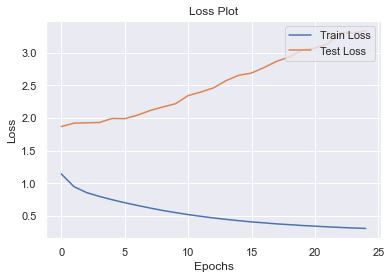

In [55]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(["Train Loss", "Test Loss"], loc ="upper right")
plt.show()

<b> NOTE:  </b>
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

# MODEL EVALUATION
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [56]:
def evaluate(image):
    attention_plot = np.zeros((max_length, 64))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using the feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [57]:
len(tokenizer.word_index) + 1

8498

### Beam Search(optional)

In [58]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption



In [59]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [60]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

data/Images/2855667597_bf6ceaef8e.jpg
<start> Four black dogs running over grass . <end>


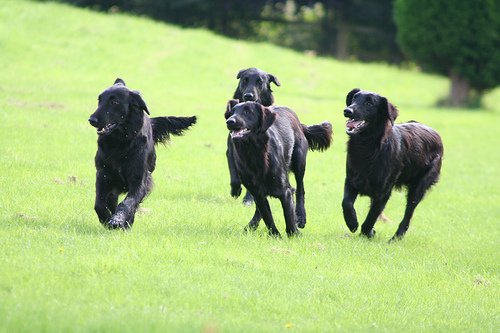

In [67]:
rid = np.random.randint(0, df.shape[0])
test_image = df['path'][rid]

real_caption = df['caption'][rid]
print(f"{test_image}")
print(f"{real_caption}")

Image.open(test_image)

BLEU score: 7.100514228897259e-153
Real Caption: Four black dogs running over grass .
Prediction Caption: four black dogs run on grass


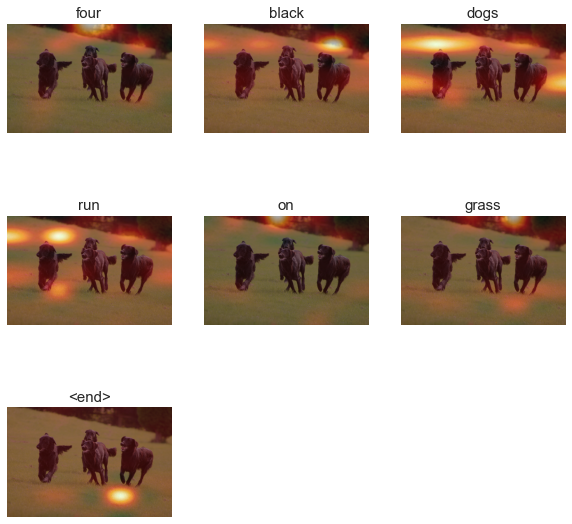

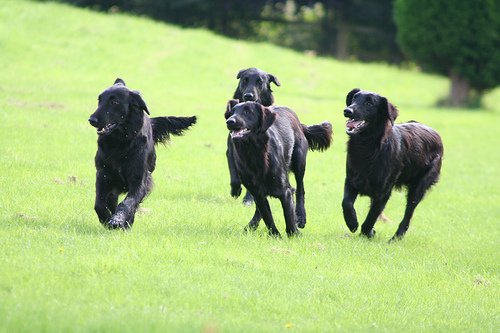

In [68]:

result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

#score = sentence_bleu(reference, candidate, weights=#set your weights)
score = sentence_bleu(reference, candidate)

print(f"BLEU score: {score*100}")
                      
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [63]:
# captions=beam_evaluate(test_image)
# print(captions)

# TEXT TO SPEECH

In [77]:
# Google's Text-to-Speech package
def generate_speech_file(caption, caption_path):
    speech_caption = gTTS("Predicted caption is: "+ caption,lang = 'en', slow = False) 
    speech_caption.save(caption_path)

In [69]:
caption_audio_file = 'tts/voice.mp3'
generate_speech_file(pred_caption, caption_audio_file)
IPython.display.display(IPython.display.Audio(caption_audio_file, rate=None,autoplay=False))

# SAVE MODELS

In [70]:
tokenizer_path = 'models/tokenizer.json'
encoder_path = 'models/encoder_captions'
decoder_weights_path = 'models/decoder_weights.h5'
decoder_json_path = 'models/decoder_captions.json'

In [71]:
# Get the current time to store as suffix to file names
current_time = datetime.datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
current_time

'2021_12_07-04_38_01_PM'

In [72]:
import io
import json
tokenizer_json = tokenizer.to_json()
with io.open(tokenizer_path, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [73]:
encoder.save(encoder_path)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models/encoder_captions/assets


2021-12-07 16:38:02.894854: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [74]:
# Currently tensorflow sub-classed models cannot be saved and loaded. 
# Hence the weights are saved. The model has to be created during deployment and weights loaded.

# serialize DECODER to JSON
model_json = decoder.to_json()
with open(decoder_json_path, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
decoder.save_weights(decoder_weights_path)
print("Saved model to disk")

Saved model to disk


# PREDICT ON UNSEEN DATA

In [85]:
def predict_caption_with_audio(test_image, speech_filepath):
    result, attention_plot,pred_test = evaluate(test_image)
    caption = ' '.join(result).rsplit(' ', 1)[0]
    print ('Predicted Caption:', caption)
    generate_speech_file(caption, speech_filepath)
    IPython.display.display(IPython.display.Audio(speech_filepath, rate=None,autoplay=False))

    display(Image.open(test_image))
    

Predicted Caption: a small white dog runs through the grass


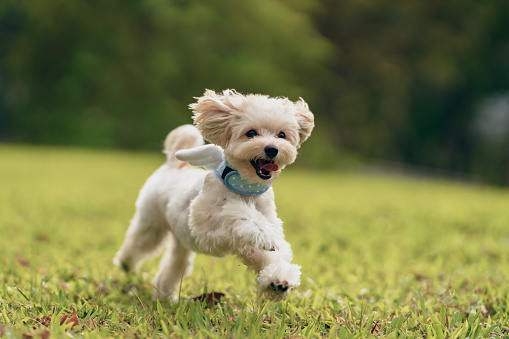

In [86]:
predict_caption_with_audio('test_data/dog1.jpeg', 'tts/voice_test_dog1.mp3')

Predicted Caption: the motorcycle is being ridden on a racetrack


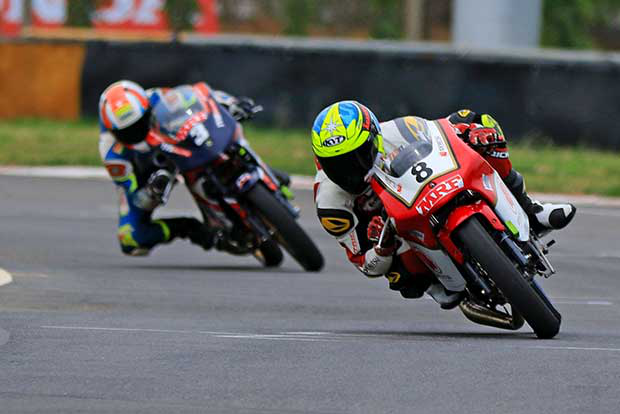

In [87]:
predict_caption_with_audio('test_data/bike1.jpeg', 'tts/voice_test_bike1.mp3')

Predicted Caption: a skier traveling down a snowy hill


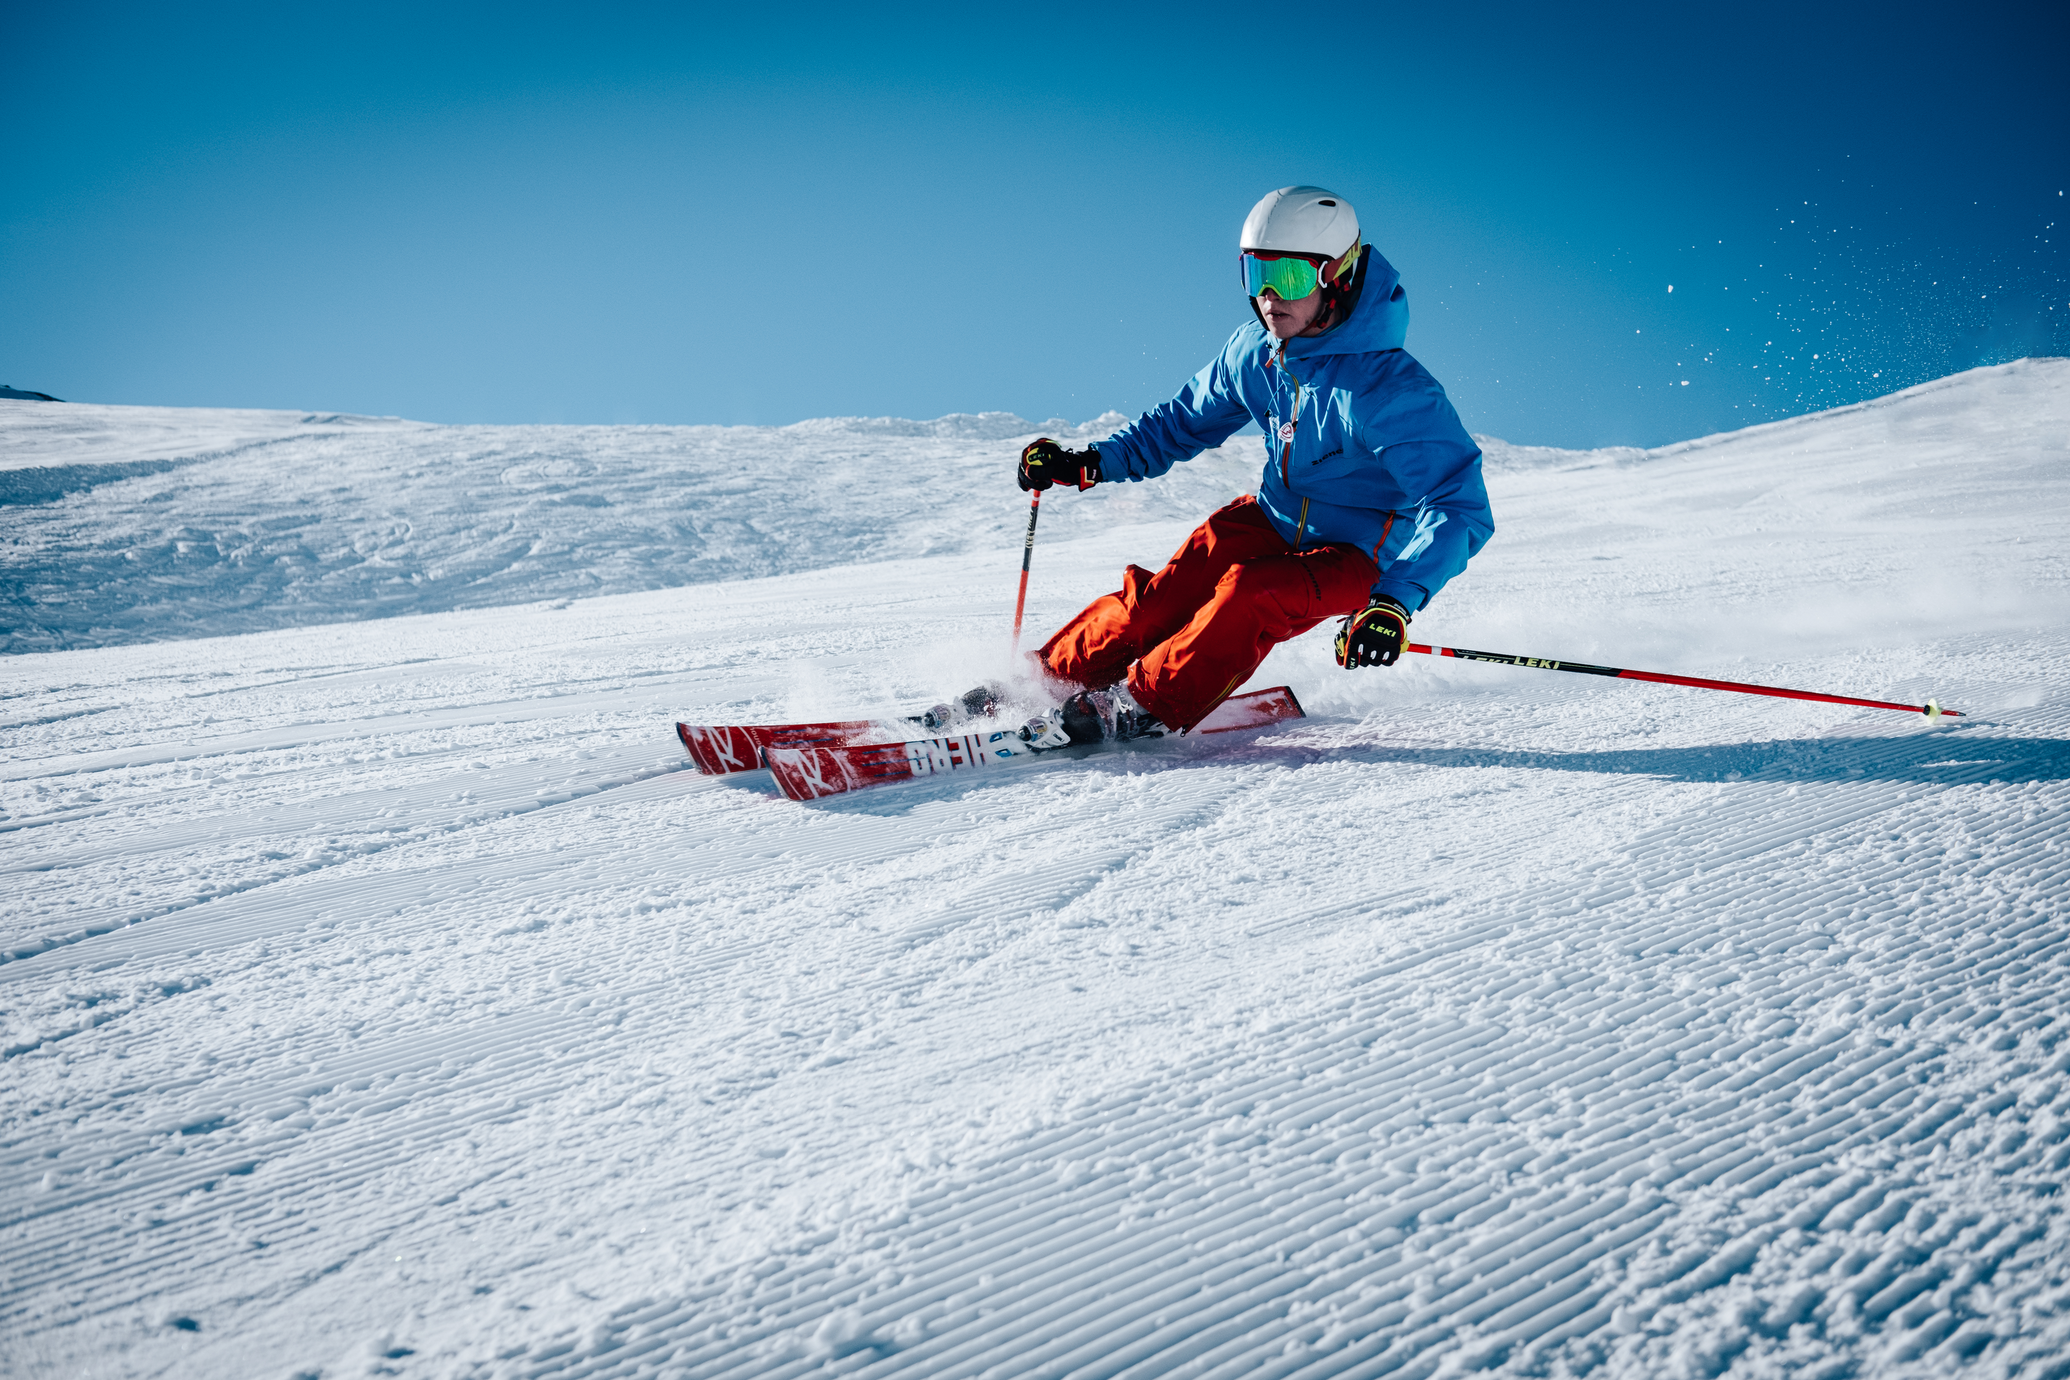

In [109]:
predict_caption_with_audio('test_data/skiing1.png', 'tts/voice_test_skiing1.mp3')

# TRY OUT

In [115]:
#plot_model(encoder,  show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Beam Search